In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import astropy.constants as cons
import astropy.units as u

from scipy import stats
import scipy.integrate as integrate
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d


np.random.seed(123)

In [3]:
fontsize = 30
labelsize = 20

#### Refer to http://www.astro.iag.usp.br/~laerte/aga0505_23/R4.html for more details on Monte Carlo simulations of a uniforme distribution of points in a sphere (or cicle)

In [4]:
#Parameters
Rmax = 5 #graus

zmin = 0.001
zmax = 1.0
z = np.arange(zmin, zmax+0.001, 0.001)

mlim = 20

H0 = 70 #km/s/Mpc
Omega_m = 0.7
Omega_l = 0.3
c = cons.c.to(u.km/u.s).value #km/s

#Defining area
rcampo = 10 #graus
ncampo = 1000 #galáxias/grau quadrado até r=20
Ncampo = np.floor(ncampo*np.pi*rcampo**2)
Ncampo = 300000

#Luminosity Function
Mstar = -21
alfa = -1.25

#Parameters for Hydra
Na = 300
z_c = 0.012
r200 = 1.0 #Mpc --> this value can be improved
Mmin = -15.5 #mlim 
dm = Na/(np.pi*Rmax**2)

x=10**(-0.4*(Mmin-Mstar))
m0 = mlim + 2.5*np.log10(x) - 5*np.log10(z_c)

xmin = lambda z: 10**(-0.4*(mlim - m0 - 5*np.log10(z)))
xmax = xmin(zmax)
Mmax = Mstar - 2.5*np.log10(xmax)

#### Spherical distribution of points: cluster (this is already done)

In [4]:
# coordenadas esfericas: (r,teta,fi)
theta = np.arccos(1 - 2*np.random.random(Na))
fi = 2*np.pi*np.random.random(Na)
r = Rmax*np.random.random(Na)**(1/3)

x_cluster = r*np.cos(fi)*np.sin(theta)
y_cluster = r*np.sin(fi)*np.sin(theta)
z_cluster = r*np.cos(theta)*H0/300000 + z_c

Text(0.5, 0, 'z')

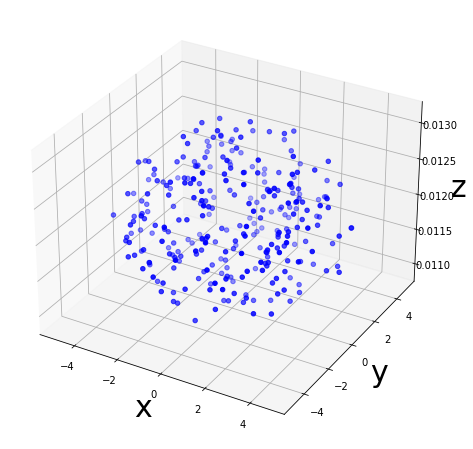

In [5]:
# visualização
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d') # criando eixos 3d
ax.scatter(x_cluster, y_cluster, z_cluster, marker= 'o',color='blue', label="Cluster")
ax.set_xlabel('x',fontsize=fontsize)
ax.set_ylabel('y',fontsize=fontsize)
ax.set_zlabel('z',fontsize=fontsize)

### Calculating redshift and magnitude distributions

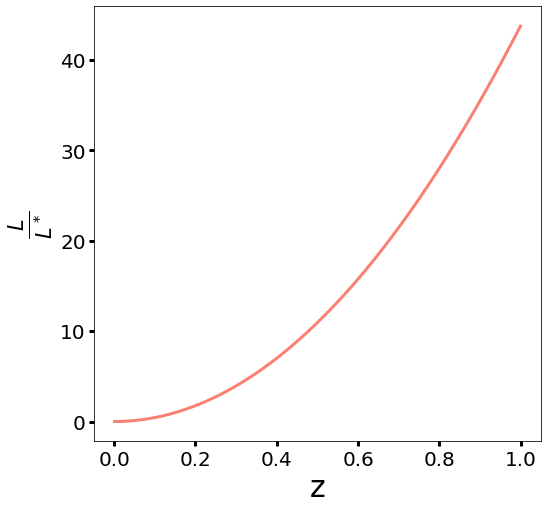

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(z, xlim(z), color="salmon", lw=3)
ax.set_ylabel(r"$\frac{L}{L^*}$", fontsize=fontsize)
ax.set_xlabel("z", fontsize=fontsize)

ax.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)

# plt.legend(fontsize=labelsize)

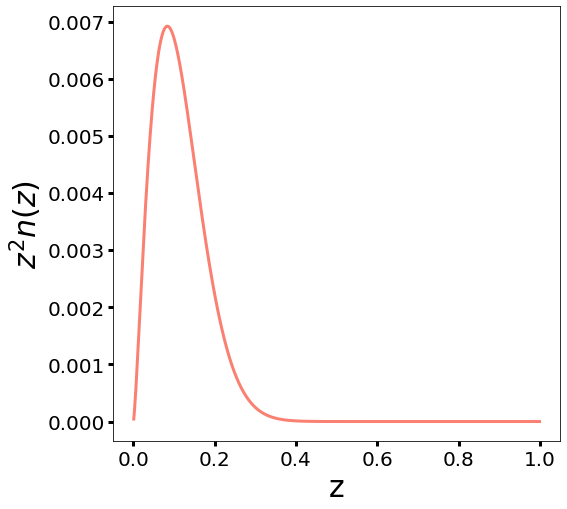

In [7]:
fl = lambda l: l**alfa * np.exp(-l)

def nz(z):
    result = z**2 * integrate.quad(fl, xlim(z), xmax)
    return result[0]

nz_arr = np.zeros_like(z)
for z_i, i in zip(z, range(len(z))):
    nz_arr[i] = nz(z_i)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(z, nz_arr * z**2, color="salmon", lw=3)
ax.set_ylabel(r"$z^2 n(z)$", fontsize=fontsize)
ax.set_xlabel("z", fontsize=fontsize)

ax.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)

# plt.legend(fontsize=labelsize)

#### Modeling the field

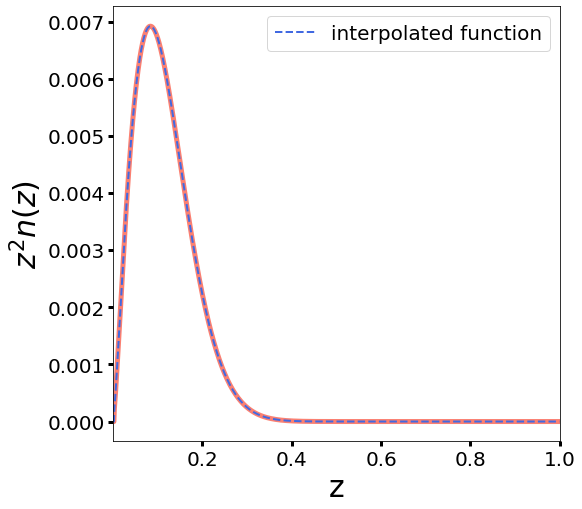

In [8]:
#Essa parte aqui não me ficou muito clara. Porque eu preciso gerar essa função aproximada nzmod? Não dá pra usar a própria nz?
#modelagem de n(z)  approxfun(x,y)
# for(i in 1:1001){
# zz[i]=(i-1)/1000
# y[i]=0
# if(i > 3)y[i]=nz(zz[i])
# }
# plot(zz,y,type='l',col='salmon',lwd=3,ylab='n(z)*z^2',xlim=c(zmin,zmax),xlab= 'z',main='distribuição esperada de redshifts')
# nzmod = approxfun(zz,y)

zz = np.zeros(1001)
y = np.zeros_like(zz)

for i in range(1001):
    zz[i] = (i - 1) / 1000
    y[i] = 0
    if i > 3:
        y[i] = nz(zz[i])
        
        
# nzmod = interp1d(zz, y)
# approxfun retorna uma função       
nzmod = lambda z : np.interp(z,zz,y)
        
    
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(111)

ax1.plot(zz, y*zz**2, color="salmon", lw=5)
ax1.set_xlim(zmin, zmax)
ax1.set_ylabel(r"$N(<z)$", fontsize=fontsize)
ax1.set_xlabel("z", fontsize=fontsize)

ax1.plot(zz, nzmod(zz)*zz**2, color="royalblue", lw=2, linestyle='--', label="interpolated function")
ax1.set_xlim(zmin, zmax)
ax1.set_ylabel(r"$z^2 n(z)$", fontsize=fontsize)
ax1.set_xlabel("z", fontsize=fontsize)

ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)

plt.legend(fontsize=labelsize)

/tmp/ipykernel_482497/324354557.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(nzmod, 0, z)[0] / integrate.quad(nzmod, 0, zmax)[0]
/tmp/ipykernel_482497/324354557.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(nzmod, 0, z)[0] / integrate.quad(nzmod, 0, zmax)[0]


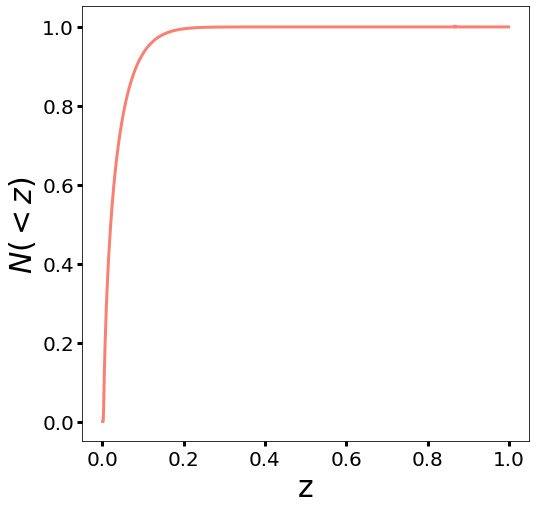

In [9]:
# N = function(z) integrate(nzmod,0,z)$value/integrate(nzmod,0,zmax)$value
#Essa parte tá demorando bastante

def N(z):
    result = integrate.quad(nzmod, 0, z)[0] / integrate.quad(nzmod, 0, zmax)[0]
    return result

N_arr = np.zeros_like(z)
for z_i, i in zip(z, range(len(z))):
    N_arr[i] = N(z_i)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(z, N_arr, color="salmon", lw=3)
ax.set_ylabel(r"$N(<z)$", fontsize=fontsize)
ax.set_xlabel("z", fontsize=fontsize)
ax.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)

In [10]:
# amostragem do campo
# Ncampo = 2000
# zcampo = np.zeros(shape=Ncampo)
# for i in range(Ncampo):
#     h = lambda x: N(x) - np.random.uniform(0, 1)
#     zcampo[i] = root_scalar(h, bracket=[0, 1]).root

import time
t0 = time.time()

Ncampo = 300000
h = lambda x: N(x) - np.random.uniform(0, 1)
zcampo = np.fromiter((root_scalar(h, bracket=[0, 1], method='brentq').root for _ in range(Ncampo)), dtype=float)
    
(time.time() - t0)/60

/tmp/ipykernel_482497/324354557.py:5: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(nzmod, 0, z)[0] / integrate.quad(nzmod, 0, zmax)[0]
/tmp/ipykernel_482497/324354557.py:5: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result = integrate.quad(nzmod, 0, z)[0] / integrate.quad(nzmod, 0, zmax)[0]
/tmp/ipykernel_482497/324354557.py:5: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result = integrate.quad(nzm

786.4624393939972

Text(0.5, 1.0, '0.005 < z < 0.015')

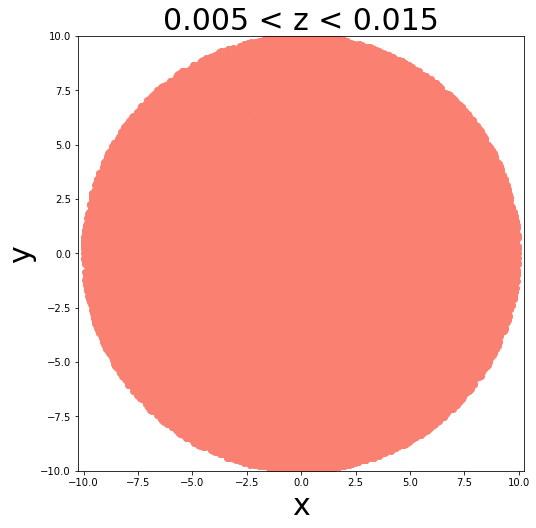

In [12]:
# distribuição espacial para galáxias de campo
# phisim = 2*pi*runif(Ncampo)
# Rsim = rcampo*runif(Ncampo)^0.5
# xcampo = Rsim*cos(phisim)
# ycampo = Rsim*sin(phisim)

#jpeg("fig4.jpg")
# par(mfrow = c(1,1))
# plot(xcampo[zcampo > 0.005 & zcampo < 0.015],ycampo[zcampo > 0.005 & zcampo < 0.015],asp=1,xlim=c(-10,10),ylim=c(-10,10),xlab='x',ylab='y', main='0.005 < z < 0.015',pch=20,col='salmon',cex=2)
#dev.off()

phisim = 2 * np.pi * np.random.random(Ncampo)
Rsim = rcampo * np.random.random(Ncampo) ** 0.5
xcampo = Rsim * np.cos(phisim)
ycampo = Rsim * np.sin(phisim)


plt.figure(figsize=(8, 8))
plt.plot(xcampo[(zcampo > 0.005) & (zcampo < 0.015)], ycampo[(zcampo > 0.005) & (zcampo < 0.015)], 'o', color='salmon', markersize=6)
plt.axis('equal')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.xlabel('x', fontsize=fontsize)
plt.ylabel('y', fontsize=fontsize)
plt.title('0.005 < z < 0.015', fontsize=fontsize)

In [13]:
#Aqui não me ficaram claros o porque dos limites de integração. Por exemplo, por vai de xlim(zcampo) até "l" no denominador??
#Eu digo isso porque lá no pdf tá definido como indo de xlim(z) até xlim(zmax) = xmax, mas aqui tá l...

Fl = lambda l, z: integrate.quad(fl, xlim(z), l)[0] / integrate.quad(fl, xlim(z), xmax)[0]

h = lambda x, z: Fl(x, z) - np.random.uniform(0, 1)
find_ll = lambda z: root_scalar(h, method='brentq', bracket=[xlim(z), xmax], args=(z)).root


mag_campo = np.zeros(Ncampo)
for i in range(Ncampo):
    ll = find_ll(zcampo[i])
    if ll > 0: mag_campo[i] = m0 - 2.5*np.log10(ll) + 5*np.log10(zcampo[i])
    if ll <= 0: mag_campo[i] = np.nan
        
        
mag_cluster = np.zeros(Na)
for i in range(Na):
    ll = find_ll(z_cluster[i])
    if ll > 0: mag_cluster[i] = m0 - 2.5*np.log10(ll) + 5*np.log10(z_cluster[i])
    if ll <= 0: mag_cluster[i] = np.nan

In [14]:
xx = np.concatenate((xcampo, x_cluster))
yy = np.concatenate((ycampo, y_cluster))
zz = np.concatenate((zcampo, z_cluster))

mag = np.concatenate((mag_campo, mag_cluster))

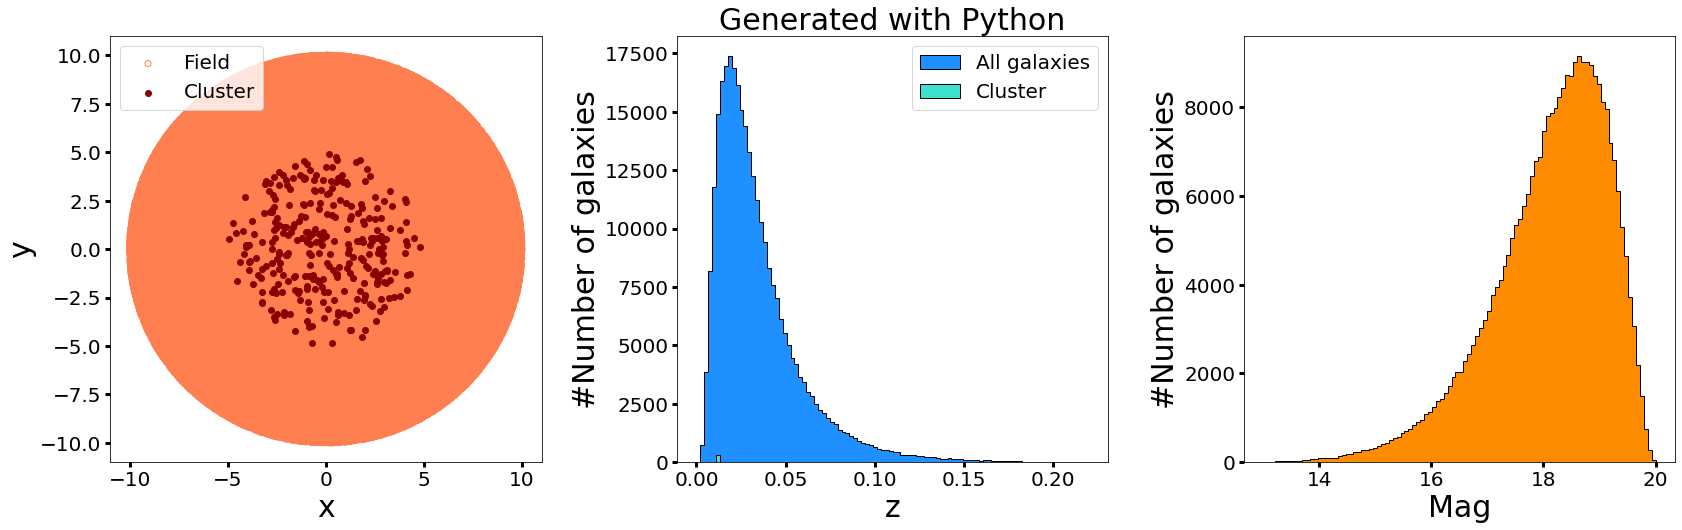

In [25]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
ax1.scatter(xcampo, ycampo, marker='o', color='coral', facecolor='none', label="Field")
ax1.scatter(x_cluster, y_cluster, marker= 'o',color='darkred', label="Cluster")
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)

ax2 = fig.add_subplot(132)
ax2.hist(zz, bins=100, color="dodgerblue", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="All galaxies")
ax2.hist(z_cluster, bins=100, color="turquoise", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="Cluster")
ax2.set_xlabel('z',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)

ax2.set_title("Generated with Python", fontsize=fontsize)

ax3 = fig.add_subplot(133)
ax3.hist(mag, bins=100, color="darkorange", histtype="stepfilled", edgecolor="black", range=[13, 20], label="All galaxies")
ax3.hist(mag_cluster, bins=100, color="wheat", histtype="stepfilled", edgecolor="black", range=[13, 20], label="Cluster")
ax3.set_xlabel('Mag',fontsize=fontsize)
ax3.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)

fig.tight_layout(pad=3.0)

### The following results were taken from the R script of Laerte

In [4]:
x_cluster_r = np.loadtxt("cluster-mock-R/xa.txt")
y_cluster_r = np.loadtxt("cluster-mock-R/ya.txt")
z_cluster_r = np.loadtxt("cluster-mock-R/za.txt")
mag_cluster_r = np.loadtxt("cluster-mock-R/mag_cluster.txt")

xcampo_r = np.loadtxt("cluster-mock-R/xcampo.txt")
ycampo_r = np.loadtxt("cluster-mock-R/ycampo.txt")
zcampo_r = np.loadtxt("cluster-mock-R/zcampo.txt")
mag_campo_r = np.loadtxt("cluster-mock-R/mag_campo.txt")

In [5]:
xx_r = np.concatenate((xcampo_r, x_cluster_r))
yy_r = np.concatenate((ycampo_r, y_cluster_r))
zz_r = np.concatenate((zcampo_r, z_cluster_r))

mag_r = np.concatenate((mag_campo_r, mag_cluster_r))

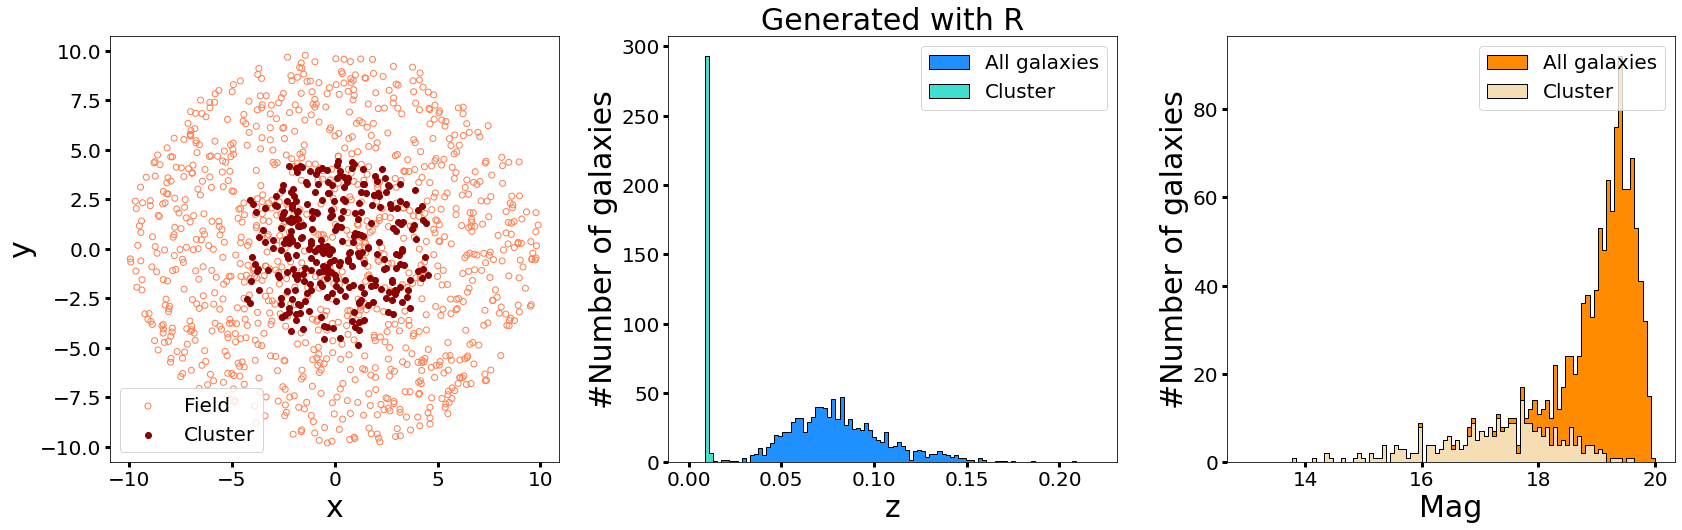

In [6]:
fig = plt.figure(figsize=(24, 8))
ax1 = fig.add_subplot(131)
ax1.scatter(xcampo_r, ycampo_r, marker='o', color='coral', facecolor='none', label="Field")
ax1.scatter(x_cluster_r, y_cluster_r, marker= 'o',color='darkred', label="Cluster")
ax1.set_xlabel('x',fontsize=fontsize)
ax1.set_ylabel('y',fontsize=fontsize)
ax1.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax1.legend(fontsize=labelsize)

ax2 = fig.add_subplot(132)
ax2.hist(zz_r, bins=100, color="dodgerblue", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="All galaxies")
ax2.hist(z_cluster_r, bins=100, color="turquoise", histtype="stepfilled", edgecolor="black", range=[0, 0.22], label="Cluster")
ax2.set_xlabel('z',fontsize=fontsize)
ax2.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax2.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax2.legend(fontsize=labelsize)

ax2.set_title("Generated with R", fontsize=fontsize)

ax3 = fig.add_subplot(133)
ax3.hist(mag_r, bins=100, color="darkorange", histtype="stepfilled", edgecolor="black", range=[13, 20], label="All galaxies")
ax3.hist(mag_cluster_r, bins=100, color="wheat", histtype="stepfilled", edgecolor="black", range=[13, 20], label="Cluster")
ax3.set_xlabel('Mag',fontsize=fontsize)
ax3.set_ylabel('#Number of galaxies',fontsize=fontsize)
ax3.xaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.yaxis.set_tick_params(labelsize=labelsize, width=3, length=5)
ax3.legend(fontsize=labelsize)

fig.tight_layout(pad=3.0)

### Adaptação para o caso relativístico

Em um Universo não-euclidiano, as distâncias não são necessariamente proporcionais ao redshift $(d \propto z)$. Ao invés disso, é mais apropriado que usemos a distância de luminosidade $D_L$:

$$
D_L = \sqrt{\frac{L}{4 \pi S}}
$$

onde L é a luminosidade bolométrica e S o fluxo bolométrico da galáxia. <br>
Uma forma ainda melhor de expressar essa quantidade é através de quantidades mais conhecidas da cosmologia. Sabe-se por exemplo que $D_L$ está relacionada à distância comóvel $D_M$ da seguinte forma

$$
D_L = (1+z) D_M
$$

sendo 

$$
D_M = D_H \frac{2 \left[ 2 - \Omega_M (1-z) - (2 - \Omega_M) \sqrt{1 + \Omega_M z} \right] }{\Omega_M^2 (1+z)}
$$

e portanto

$$
D_L =  \frac{2c}{H_0} \frac{\left[ 2 - \Omega_M (1-z) - (2 - \Omega_M) \sqrt{1 + \Omega_M z} \right] }{\Omega_M^2}
$$
uma vez que a distância de Hubble é $D_H = \frac{c}{H_0}$. <br>

Por conta disso, algumas modificações serão necessárias na construção do Mock, especialmente no cálculo das magnitudes:

#### 1. Na expressão para a magnitude, precisamos mudar de z para $D_L$:

$$
m = m_0 - 2.5logx + 5log \left( \frac{D_L}{10pc} \right)
$$

#### 2. No lugar de $z_{min}$, vamos usar $D_{L, min}$:

$$
D_{L, min} =  \frac{2c}{H_0} \frac{\left[ 2 - \Omega_M (1-z_{min}) - (2 - \Omega_M) \sqrt{1 + \Omega_M z_{min}} \right] }{\Omega_M^2}
$$

#### 3. Dessa forma, $m_0$ passa a ser dado por

$$
m_0 = m_{lim} + 2.5log(x_{min}) - 5log \left( \frac{D_{L,min}}{10pc} \right)
$$

#### 4. E  $x_{min}(z)$ passa a ser

$$
x_{min}(D_L) = \frac{L_{min}(D_L)}{L^*} = 10^{-0.4 \left( m_{lim} - m_0 - 5log \left( \frac{D_{L}}{10pc} \right) \right)}
$$

Uma outra adaptação necessária vai ser em relação ao elemento de volume utilizado para o cálculo do número cumulativo de galáxias, $N(< z)$. 

$$
N(< z) = \int_{z_{min}}^z n(z) dV
$$

O elemento de volume comóvel, $dV_c$ é dado por

$$
dV_c = D_H \frac{(1+z)^2 D_A^2}{E(z)} d \Omega dz
$$

com $E(z)$ sendo

$$
E(z) \equiv \sqrt{\Omega_M (1+z)^3 + \Omega_K (1+z)^2 + \Omega_{\Lambda}}
$$

de forma que 

$$
N(<z) \propto \int_{z_{min}}^z \frac{(1+z)^2 n(z) dz}{\sqrt{\Omega_M (1+z)^3 + \Omega_K (1+z)^2 + \Omega_{\Lambda}}}
$$

In [12]:
#Let's calculate DLmin and m0
DLmin = (2*c/H0) * (2 - Omega_m*(1-zmin) - (2-Omega_m)*np.sqrt(1+Omega_m*zmin)) / (Omega_m**2) #Mpc
DLmin *= u.Mpc
# DLmin = DLmin.to(u.pc)
print("DL_min(zmin={:.3f}) = {:.2f} Mpc".format(zmin, DLmin.value))

DL_min(zmin=0.001) = 4.28 Mpc


In [6]:
z_c = 0.01
DL_zc = (2*c/H0) * (2 - Omega_m*(1-z_c) - (2-Omega_m)*np.sqrt(1+Omega_m*z_c)) / (Omega_m**2) #Mpc
DL_zc *= u.Mpc

m0 = mlim + 2.5*np.log10(x) - 5*np.log10(DL_zc.value)
print("m0(zmin={:.3f}) = {:.2f}".format(z_c, m0))

m0(zmin=0.010) = 6.33
